In [37]:
%matplotlib inline

import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import sys

def print_fl(output):
    print(output)
    sys.stdout.flush()

def get_raw_filename(sim_id, num_pol, T, F):
    return "../perm-sim-id-%s-numpol-%d-T-%.2f-F-%.2f.npz" % (sim_id, num_pol, T, F)

def get_summary_filename(sim_id, num_pol, T, F):
    return "../summaries/perm-summary-%s-numpol-%d-T-%.2f-F-%.2f.npz" % (sim_id, num_pol, T, F)

def calculate_weighted_stddevs(qty, ws, n, axis=0):
    avg_qty = np.average(qty, axis=axis, weights=ws)
    dsq_qty = (qty - avg_qty)**2
    var_qty = np.average(dsq_qty, axis=axis, weights=ws)
    return np.sqrt(var_qty / n)

In [2]:
sim_id = "jt50k"
num_pol = 50000
Ts = np.linspace(0.02, 2.0, 100)
Fs = np.array([0.0])

In [7]:
def transcribe_summaries():
    for F in Fs:
        print_fl("Processing F: %.2f" % (F))
        for T in Ts:
            print_fl("Processing T: %.2f" % (T))
            with np.load(get_raw_filename(sim_id, num_pol, T, F)) as rawData:
                sumData = dict()
                sumData["pol_weight_renormalization"] = rawData["pol_weight_renormalization"]
                sumData["epsilon"] = rawData["epsilon"]
                sumData["n_theta"] = rawData["n_theta"]
                sumData["sigma"] = rawData["sigma"]
                sumData["enable_LJ_interaction"] = rawData["enable_LJ_interaction"]
                sumData["n_dim"] = rawData["n_dim"]
                sumData["F"] = rawData["F"]
                sumData["n"] = rawData["n"]
                sumData["T"] = rawData["T"]
                sumData["F"] = rawData["F"]
                sumData["max_size"] = rawData["max_size"]
                sumData["d"] = rawData["d"]

                #sumData["r_end"] = rawData["r_end"]
                sumData["final_weights"] = rawData["pol_weights"][:,-1]

                sumData["x_e2e"] = np.average(rawData["r_end"][:,:,0], axis=0, weights=rawData["pol_weights"])
                sumData["y_e2e"] = np.average(rawData["r_end"][:,:,1], axis=0, weights=rawData["pol_weights"])

                sumData["x_e2e_sd"] = calculate_weighted_stddevs(rawData["r_end"][:,:,0], rawData["pol_weights"], num_pol)
                sumData["y_e2e_sd"] = calculate_weighted_stddevs(rawData["r_end"][:,:,1], rawData["pol_weights"], num_pol)

                sumData["r_e2e"] = np.average(rawData["r_e2e"], axis=0, weights=rawData["pol_weights"])
                sumData["r_gyration"] = np.average(rawData["r_gyration"], axis=0, weights=rawData["pol_weights"])
                sumData["energies"] = np.average(rawData["energies"], axis=0, weights=rawData["pol_weights"])

                sumData["r_e2e_sd"] = calculate_weighted_stddevs(rawData["r_e2e"], rawData["pol_weights"], num_pol)
                sumData["r_gyration_sd"] = calculate_weighted_stddevs(rawData["r_gyration"], rawData["pol_weights"], num_pol)
                sumData["energies_sd"] = calculate_weighted_stddevs(rawData["energies"], rawData["pol_weights"], num_pol)

                np.savez(get_summary_filename(sim_id, num_pol, T, F), **sumData)

In [23]:
r_e2e_T = np.zeros_like(Ts)
r_gyr_T = np.zeros_like(Ts)

r_e2e_T_sd = np.zeros_like(Ts)
r_gyr_T_sd = np.zeros_like(Ts)

for i in range(len(Ts)):
    with np.load(get_summary_filename(sim_id, num_pol, Ts[i], 0.0)) as data:
        r_e2e_T[i] = data["r_e2e"][-1]
        r_gyr_T[i] = data["r_gyration"][-1]
        
        r_e2e_T_sd[i] = data["r_e2e_sd"][-1]
        r_gyr_T_sd[i] = data["r_gyration_sd"][-1]

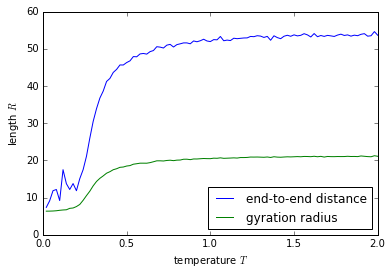

In [117]:
#plt.errorbar(Ts, r_e2e_T, yerr=r_e2e_T_sd, label=r"end-to-end distance")
#plt.errorbar(Ts, r_gyr_T, yerr=r_gyr_T_sd, label=r"gyration radius")

plt.plot(Ts, r_e2e_T, label=r"end-to-end distance")
plt.plot(Ts, r_gyr_T, label=r"gyration radius")

plt.legend(loc=4)
plt.xlabel(r"temperature $T$")
plt.ylabel(r"length $R$")

#plt.savefig("temperature-dependence.png",dpi=300)

#plt.xlim(0.25,2.0)
plt.show()

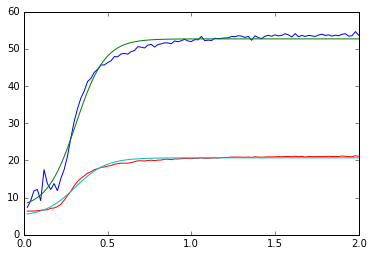

In [70]:
curvelc = lambda x, a, b, c, d: a/(1+np.exp(-(x+c)/b)) + d
p, _ = scipy.optimize.curve_fit(curvelc, Ts, r_e2e_T, p0=[55, 0.2, 0.0, 0.0], maxfev=10000)
p_g, _ = scipy.optimize.curve_fit(curvelc, Ts, r_gyr_T, p0=[20, 0.002, -0.25, 7], maxfev=10000)

plt.plot(Ts, r_e2e_T)
plt.plot(Ts, curvelc(Ts, *p))

plt.plot(Ts, r_gyr_T)
plt.plot(Ts, curvelc(Ts, *p_g))

(0.28, 2.0)

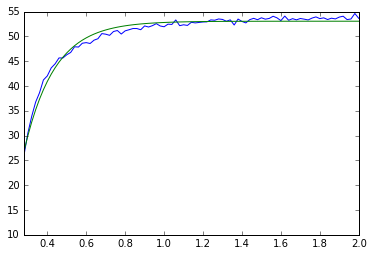

In [72]:
plt.plot(Ts[10:], r_e2e_T[10:])

curve = lambda x, a, b, c: a*(1-np.exp(-(x+c)/b))

p, _ = scipy.optimize.curve_fit(curve, Ts[10:], r_e2e_T[10:], p0=[55, 0.2, 0.0])

plt.plot(Ts[10:], curve(Ts[10:], *p))
plt.xlim(0.28,2.0)

In [75]:
Ts[13]

0.28000000000000003

In [77]:
loT = 3
hiT = 80
mdT = 13

loData = np.load(get_raw_filename(sim_id, num_pol, Ts[loT], 0.0))
mdData = np.load(get_raw_filename(sim_id, num_pol, Ts[mdT], 0.0))
hiData = np.load(get_raw_filename(sim_id, num_pol, Ts[hiT], 0.0))

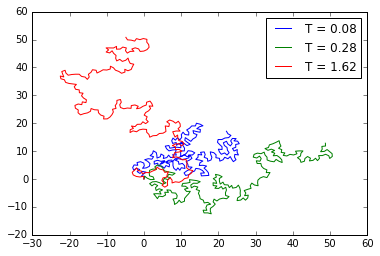

In [81]:
pol = 34554

plt.plot(loData["r"][pol,:,0], loData["r"][pol,:,1], label="T = %.2f" % Ts[loT])
plt.plot(mdData["r"][pol,:,0], mdData["r"][pol,:,1], label="T = %.2f" % Ts[mdT])
plt.plot(hiData["r"][pol,:,0], hiData["r"][pol,:,1], label="T = %.2f" % Ts[hiT])
plt.legend()

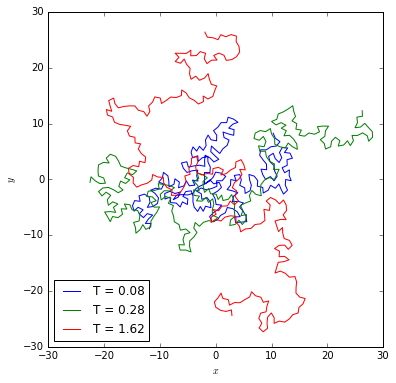

In [87]:
pol = 34554

plt.figure(figsize=(6,6))

plt.plot(loData["r"][pol,:,0] - np.mean(loData["r"][pol,:,0]), loData["r"][pol,:,1] - np.mean(loData["r"][pol,:,1]), label="T = %.2f" % Ts[loT])
plt.plot(mdData["r"][pol,:,0] - np.mean(mdData["r"][pol,:,0]), mdData["r"][pol,:,1] - np.mean(mdData["r"][pol,:,1]), label="T = %.2f" % Ts[mdT])
plt.plot(hiData["r"][pol,:,0] - np.mean(hiData["r"][pol,:,0]), hiData["r"][pol,:,1] - np.mean(hiData["r"][pol,:,1]), label="T = %.2f" % Ts[hiT])
plt.axis('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(loc=3)
plt.savefig("3-polymers-in-diff-phases.png", dpi=300)

In [90]:
loSumData = np.load(get_summary_filename(sim_id, num_pol, Ts[loT], 0.0))
mdSumData = np.load(get_summary_filename(sim_id, num_pol, Ts[mdT], 0.0))
hiSumData = np.load(get_summary_filename(sim_id, num_pol, Ts[hiT], 0.0))

bd = np.arange(250)

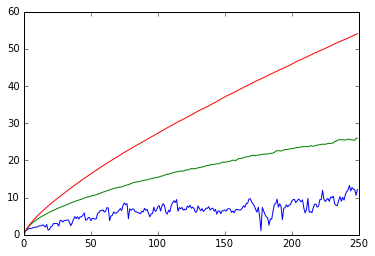

In [119]:
plt.errorbar(bd, loSumData["r_e2e"], label="T = %.2f" % Ts[loT])
plt.plot(bd, mdSumData["r_e2e"], label="T = %.2f" % Ts[mdT])
plt.plot(bd, hiSumData["r_e2e"], label="T = %.2f" % Ts[hiT])

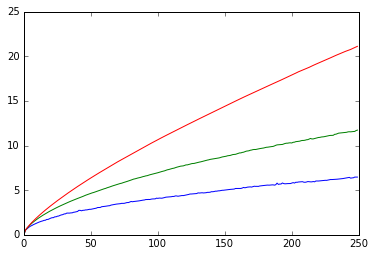

In [130]:
plt.errorbar(bd, loSumData["r_gyration"], label="T = %.2f" % Ts[loT])
plt.plot(bd, mdSumData["r_gyration"], label="T = %.2f" % Ts[mdT])
plt.plot(bd, hiSumData["r_gyration"], label="T = %.2f" % Ts[hiT])

[ 0.4089354   0.96041777]
[ 0.56722197  1.14079755]
[ 0.74445066  0.88880383]


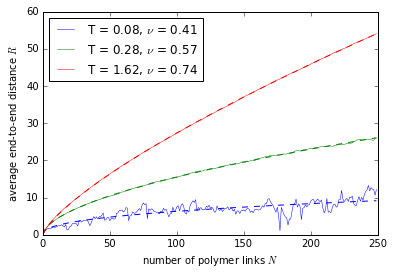

In [116]:
fitfunc = lambda x, a, b: b*x**a

pLo, _ = scipy.optimize.curve_fit(fitfunc, bd, loSumData["r_e2e"])
pMd, _ = scipy.optimize.curve_fit(fitfunc, bd, mdSumData["r_e2e"])
pHi, _ = scipy.optimize.curve_fit(fitfunc, bd, hiSumData["r_e2e"])

print(pLo)
print(pMd)
print(pHi)

plt.plot(bd, loSumData["r_e2e"], label=r"T = %.2f, $\nu$ = %.2f" % (Ts[loT], pLo[0]), color="b", linewidth=0.5)
plt.plot(bd, fitfunc(bd, *pLo), color="b", linestyle="dashed")

plt.plot(bd, mdSumData["r_e2e"], label=r"T = %.2f, $\nu$ = %.2f" % (Ts[mdT], pMd[0]), color="g", linewidth=0.5)
plt.plot(bd, fitfunc(bd, *pMd), color="g", linestyle="dashed")

plt.plot(bd, hiSumData["r_e2e"], label=r"T = %.2f, $\nu$ = %.2f" % (Ts[hiT], pHi[0]), color="r", linewidth=0.5)
plt.plot(bd, fitfunc(bd, *pHi), color="r", linestyle="dashed")

plt.legend(loc=2)
plt.xlabel(r"number of polymer links $N$")
plt.ylabel(r"average end-to-end distance $R$")

plt.savefig("length-vs-beads-3-temps.png", dpi=300)

[ 0.49459567  0.42066549]
[ 0.57559264  0.49028112]
[ 0.7465117  0.3426717]


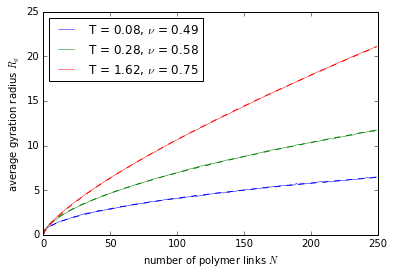

In [133]:
fitfunc = lambda x, a, b: b*x**a

pGLo, _ = scipy.optimize.curve_fit(fitfunc, bd, loSumData["r_gyration"])
pGMd, _ = scipy.optimize.curve_fit(fitfunc, bd, mdSumData["r_gyration"])
pGHi, _ = scipy.optimize.curve_fit(fitfunc, bd, hiSumData["r_gyration"])

print(pGLo)
print(pGMd)
print(pGHi)

plt.plot(bd, loSumData["r_gyration"], label=r"T = %.2f, $\nu$ = %.2f" % (Ts[loT], pGLo[0]), color="b", linewidth=0.5)
plt.plot(bd, fitfunc(bd, *pGLo), color="b", linestyle="dashed")

plt.plot(bd, mdSumData["r_gyration"], label=r"T = %.2f, $\nu$ = %.2f" % (Ts[mdT], pGMd[0]), color="g", linewidth=0.5)
plt.plot(bd, fitfunc(bd, *pGMd), color="g", linestyle="dashed")

plt.plot(bd, hiSumData["r_gyration"], label=r"T = %.2f, $\nu$ = %.2f" % (Ts[hiT], pGHi[0]), color="r", linewidth=0.5)
plt.plot(bd, fitfunc(bd, *pGHi), color="r", linestyle="dashed")

plt.legend(loc=2)
plt.xlabel(r"number of polymer links $N$")
plt.ylabel(r"average gyration radius $R_g$")

plt.savefig("gyration-vs-beads-3-temps.png", dpi=300)

In [124]:
recalc_e2e = np.linalg.norm(hiData["r"][:,-1,:], axis = 1)
r_e2e = hiData["r_e2e"][:,-1]

In [129]:
np.sum(np.abs(recalc_e2e - r_e2e))

34584.453722756756